<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
# !pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кирилл\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
from nltk.corpus import stopwords
import string

nltk.download('punkt')

sentences = []
words = []
word_threshold = 32
stop_words = set(stopwords.words('english'))

def filter_sentence(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence.lower()

for text in tqdm(dataset["train"]["text"]):
    processed_sentences = [filter_sentence(sentence) for sentence in sent_tokenize(text) if len(sentence.split()) < word_threshold]
    sentences.extend(processed_sentences)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кирилл\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
len(sentences)

219930

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 219930


Посчитаем для каждого слова его встречаемость.

In [9]:
words_count = Counter()
corpus = []
for sentence in tqdm(sentences):
    words = word_tokenize(sentence)
    corpus.append(words)
    for word in words:
        words_count[word] += 1
# Расчет встречаемости слов

  0%|          | 0/219930 [00:00<?, ?it/s]

In [67]:
print(f"Всего уникальных \"слов\" в нашем наборе предложений: {len(words_count)}")

Всего уникальных "слов" в нашем наборе предложений: 82138


In [11]:
words_count_ordered = dict(words_count.most_common()) # Теперь у нас упорядоченный словарь от самых частых "слов" до самых редких

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [12]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

for word in list(words_count_ordered.keys()):
    vocab.add(word)
    if len(vocab) == vocab_size + 4:
        break

In [13]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [14]:
vocab = list(vocab)
vocab[:6]

['wolvie', 'approaches', 'antisemitic', 'anakin', 'lameo', 'colourless']

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [15]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [16]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [17]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [18]:
train_sentences, eval_sentences = train_test_split(corpus, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [19]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [20]:
def train_model(model: nn.Module, train_dataloader: DataLoader, eval_dataloader: DataLoader, num_epoch: int) -> tuple:
    losses = []
    perplexities = []
    
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for batch in train_dataloader:
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
        print(f'Эпоха {epoch+1} обучена. Лосс: {losses[-1]}, перплексия: {perplexities[-1]}')
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [21]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [22]:
## tqdm ломает обучение, так что без красивостей на сегодня
model_rnn = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
losses_rnn, perplexities_eval_rnn = train_model(model_rnn, train_dataloader, eval_dataloader, num_epoch=7)

Эпоха 1 обучена. Лосс: 6.167904210177335, перплексия: 290.99369403927824
Эпоха 2 обучена. Лосс: 5.485603666825728, перплексия: 232.3774967637173
Эпоха 3 обучена. Лосс: 5.245300076918168, перплексия: 213.1638735394145
Эпоха 4 обучена. Лосс: 5.087063459222967, перплексия: 209.39590170217116
Эпоха 5 обучена. Лосс: 4.9671757403287025, перплексия: 210.4171536467796
Эпоха 6 обучена. Лосс: 4.869303650249134, перплексия: 214.80063886420672
Эпоха 7 обучена. Лосс: 4.788350267236883, перплексия: 216.53852888595227


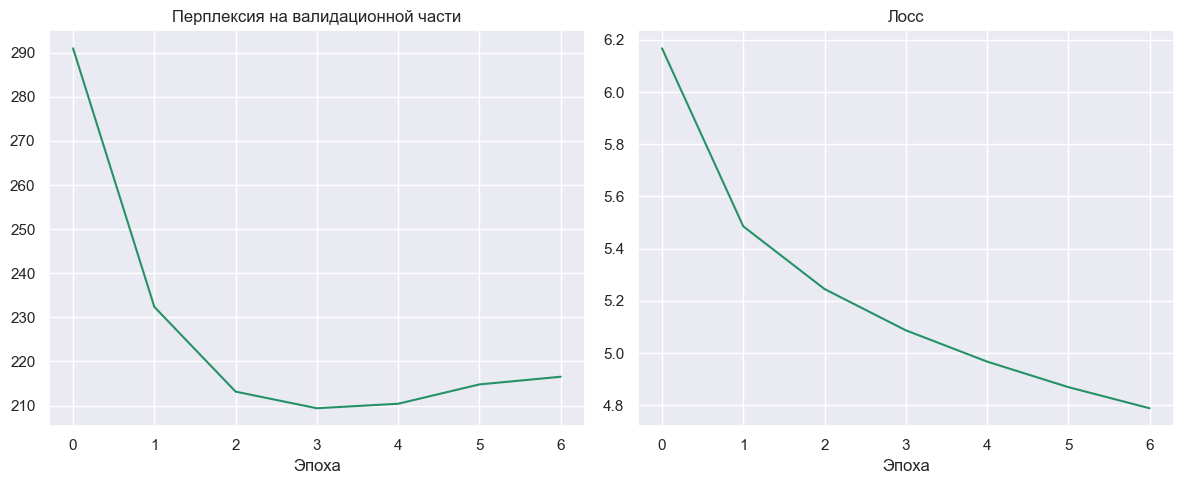

Минимальная перплексия: 209.39590170217116


In [23]:
def draw(losses: List, perplexities: List):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Лосс')
    plt.xlabel("Эпоха")

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(perplexities)), perplexities)
    plt.title('Перплексия на валидационной части')
    plt.xlabel("Эпоха")
    plt.tight_layout()
    plt.show()
    print(f'Минимальная перплексия: {min(perplexities)}')

draw(losses_rnn, perplexities_eval_rnn)

Архитектура на обычном однослойном RNN с 256 скрытыми слоями показывает минимальную перплексию 209 едениц. Видно, что после третьей эпохи результат перестал улучшаться. 
Попробуем заменить RNN на LSTM и посмотреть станет ли результат лучше. 

In [24]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    device = 'cuda'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in nltk.word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model_rnn, "that film is so bad that is")

'<bos> that film is so bad that is not a good movie <eos>'

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [25]:
class LanguageModel_lstm(LanguageModel):
     def __init__(self, hidden_dim: int, vocab_size: int) -> None:
        super(LanguageModel_lstm, self).__init__(hidden_dim, vocab_size)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

Эпоха 1 обучена. Лосс: 6.207496350721879, перплексия: 291.83866367783656
Эпоха 2 обучена. Лосс: 5.471400152379816, перплексия: 219.84173300099928
Эпоха 3 обучена. Лосс: 5.207017632917925, перплексия: 196.78917525535405
Эпоха 4 обучена. Лосс: 5.030143907373602, перплексия: 188.2813959343489
Эпоха 5 обучена. Лосс: 4.89248778776689, перплексия: 185.57525608151457
Эпоха 6 обучена. Лосс: 4.778283045335249, перплексия: 186.64843679028888
Эпоха 7 обучена. Лосс: 4.680018095883456, перплексия: 189.75169195130815


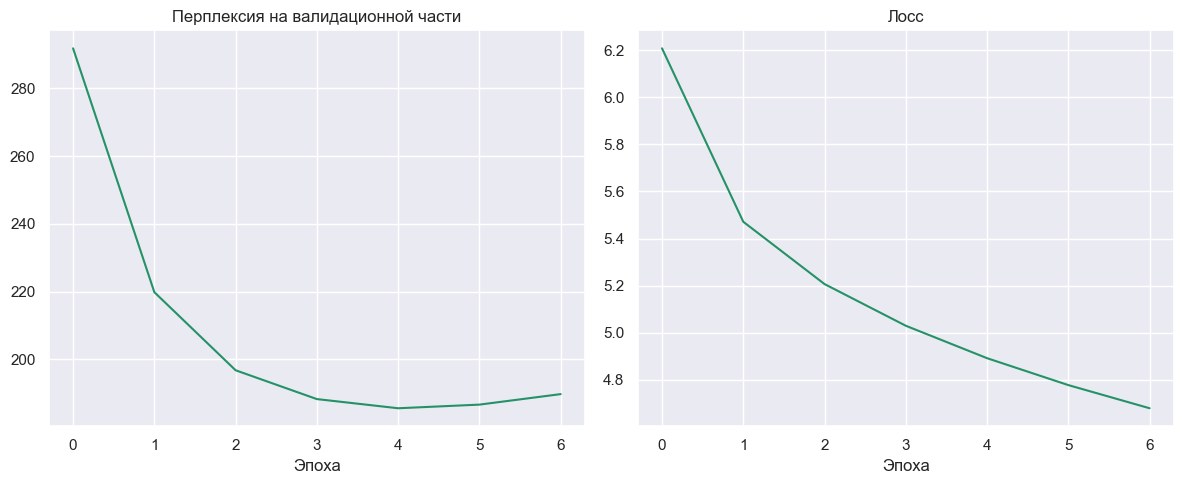

Минимальная перплексия: 185.57525608151457


In [26]:
torch.cuda.empty_cache()
model_lstm = LanguageModel_lstm(hidden_dim=256, vocab_size=len(vocab)).to(device)
losses_lstm, perplexities_eval_lstm = train_model(model_lstm, train_dataloader, eval_dataloader, num_epoch=7)
draw(losses_lstm, perplexities_eval_lstm)

Замена RNN на LSTM улучшила результат в лучшей эпохе на ~10%. Также обучение после 4й эпохе не улучшает результат

In [27]:
generate_sequence(model_lstm, "that film is so bad that is")

'<bos> that film is so bad that is not a good movie <eos>'

Эпоха 1 обучена. Лосс: 6.05540689052235, перплексия: 238.11905599194904
Эпоха 2 обучена. Лосс: 5.249090575478293, перплексия: 188.60311827548713
Эпоха 3 обучена. Лосс: 4.929722574060613, перплексия: 180.6843481729197
Эпоха 4 обучена. Лосс: 4.69045040546764, перплексия: 184.42466274527615
Эпоха 5 обучена. Лосс: 4.486999672282826, перплексия: 193.8434926410054
Эпоха 6 обучена. Лосс: 4.305387953844938, перплексия: 207.8130814308344
Эпоха 7 обучена. Лосс: 4.1412308309728445, перплексия: 225.60449520377225


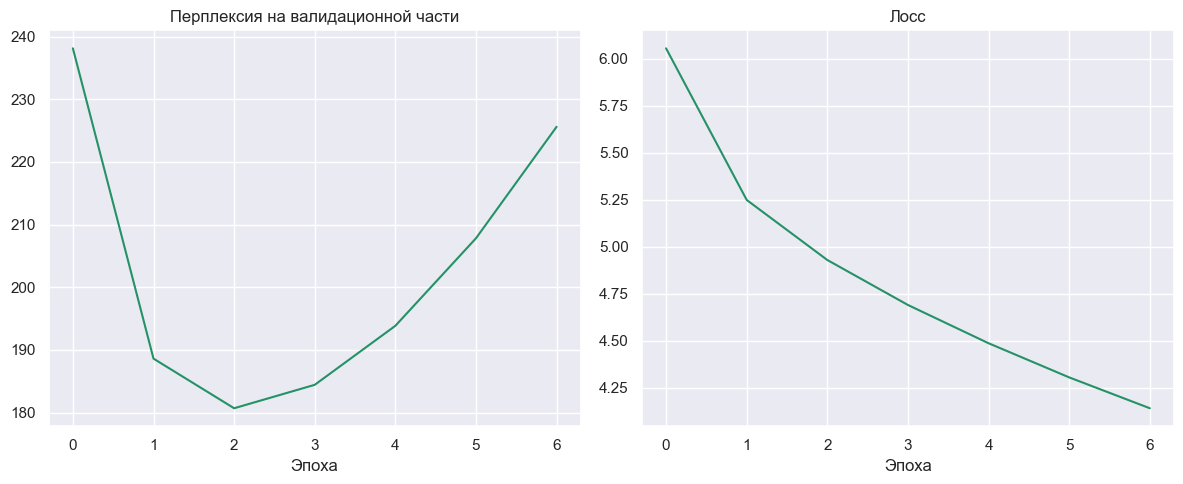

Минимальная перплексия: 180.6843481729197


In [28]:
torch.cuda.empty_cache()
model_lstm_deep = LanguageModel_lstm(hidden_dim=512, vocab_size=len(vocab)).to(device)
losses_lstm_deep, perplexities_eval_lstm_deep = train_model(model_lstm_deep, train_dataloader, eval_dataloader, num_epoch=7)
draw(losses_lstm_deep, perplexities_eval_lstm_deep)

Увеличение скрытой ращмерности в однослой LSTM чуть улучшило лучший результат, однако после уже второй эпохи модель начинает сильно переобучаться. Посмотрим можно ли хорошо регуляризировать модель при помощи увеличения drop_out. Замечу, что сгенерированное предложение хоть и получилось глуповатым, но хотя бы не нарушает логику. Но на самом деле это ничего не говорит нам о качестве модели

In [66]:
generate_sequence(model_lstm_deep, "that film is so bad that is")

'<bos> that film is so bad that is not the best of the year <eos>'

In [30]:
class LanguageModel_drop(LanguageModel):
     def __init__(self, hidden_dim: int, vocab_size: int) -> None:
        super(LanguageModel_drop, self).__init__(hidden_dim, vocab_size)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(p=0.33)

Эпоха 1 обучена. Лосс: 6.407569000590931, перплексия: 377.1919701154842
Эпоха 2 обучена. Лосс: 5.60858629989624, перплексия: 268.29832706894985
Эпоха 3 обучена. Лосс: 5.3497462720004, перплексия: 239.69175968613735
Эпоха 4 обучена. Лосс: 5.191952824332497, перплексия: 227.6709388023199
Эпоха 5 обучена. Лосс: 5.075041242079301, перплексия: 224.22770114277685
Эпоха 6 обучена. Лосс: 4.981235541603782, перплексия: 223.68568801879883
Эпоха 7 обучена. Лосс: 4.901440332239324, перплексия: 231.67594537069633


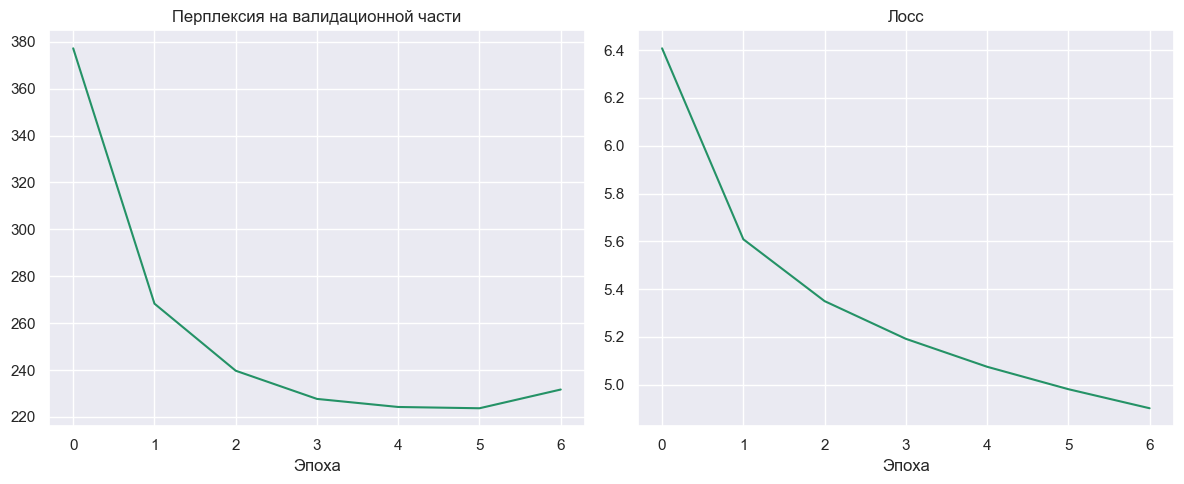

Минимальная перплексия: 223.68568801879883


In [31]:
torch.cuda.empty_cache()
model_lstm_drop = LanguageModel_drop(hidden_dim=256, vocab_size=len(vocab)).to(device)
losses_lstm_drop, perplexities_eval_lstm_drop = train_model(model_lstm_drop, train_dataloader, eval_dataloader, num_epoch=7)
draw(losses_lstm_drop, perplexities_eval_lstm_drop)

Увелечение вероятности в drop_out'е привело к увеличению стабильности улучшения перплексии, однако она сама пока имеет худшее значение из всех экспериментов

In [32]:
generate_sequence(model_lstm_drop, "that film is so bad that is")

'<bos> that film is so bad that is the same <eos>'

In [33]:
class LanguageModel_deep_layer_LSTM(LanguageModel):
     def __init__(self, hidden_dim: int, vocab_size: int) -> None:
        super(LanguageModel_deep_layer_LSTM, self).__init__(hidden_dim, vocab_size)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)

Эпоха 1 обучена. Лосс: 6.938029004530473, перплексия: 1326.3931299253952
Эпоха 2 обучена. Лосс: 6.896283879713579, перплексия: 1139.8938928648483
Эпоха 3 обучена. Лосс: 5.944739447853782, перплексия: 248.14854573094567
Эпоха 4 обучена. Лосс: 5.289735483689742, перплексия: 202.22673593565474
Эпоха 5 обучена. Лосс: 5.0277685428966175, перплексия: 190.5581615359284
Эпоха 6 обучена. Лосс: 4.832232991305265, перплексия: 191.5741142450377
Эпоха 7 обучена. Лосс: 4.663771244395863, перплексия: 198.44113744691361


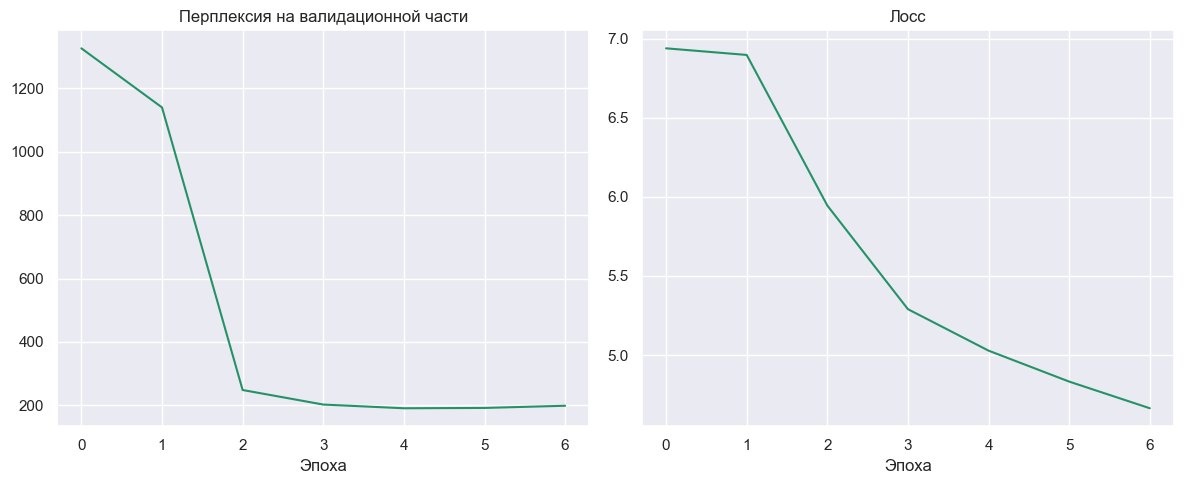

Минимальная перплексия: 190.5581615359284


In [35]:
torch.cuda.empty_cache()
model_lstm_deep_layer = LanguageModel_deep_layer_LSTM(hidden_dim=512, vocab_size=len(vocab)).to(device)
losses_lstm_deep_layer, perplexities_eval_lstm_deep_layer = train_model(model_lstm_deep_layer, train_dataloader, eval_dataloader, num_epoch=7)
draw(losses_lstm_deep_layer, perplexities_eval_lstm_deep_layer)

LSTM с двумя слоями, увеличенной скрытой размерностью и увеличенной вероятностью дропаута ведёт себя отлично от предыдущих экспериментов. В первых двух эпохах значения перплексии неожиданно большие, а затем резко снижаются. Итоговые результаты не соответсвуют ожиданиям. Не смотря на долгое время обучения итоговая перплексия лучше чем у ванильной реализации RNN, но не сильно и уступает простой реализации LSTM. Из интересного эта модель не показывает признаков переобучения на 7ми эпохах. Возможно, стоит попробовать учить её дальше

In [36]:
generate_sequence(model_lstm_deep_layer, "that film is so bad that is")

'<bos> that film is so bad that is it <eos>'

In [44]:
class LanguageModel_3(LanguageModel):
     def __init__(self, hidden_dim: int, vocab_size: int) -> None:
        super(LanguageModel_3, self).__init__(hidden_dim, vocab_size)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=3, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)

Эпоха 1 обучена. Лосс: 6.9360678135265, перплексия: 1301.0675595305686
Эпоха 2 обучена. Лосс: 6.567505802501332, перплексия: 577.7163124971612
Эпоха 3 обучена. Лосс: 5.986967675295743, перплексия: 439.0303445860397
Эпоха 4 обучена. Лосс: 5.779714404366233, перплексия: 388.91480876124183
Эпоха 5 обучена. Лосс: 5.649822547912597, перплексия: 380.7319087538608


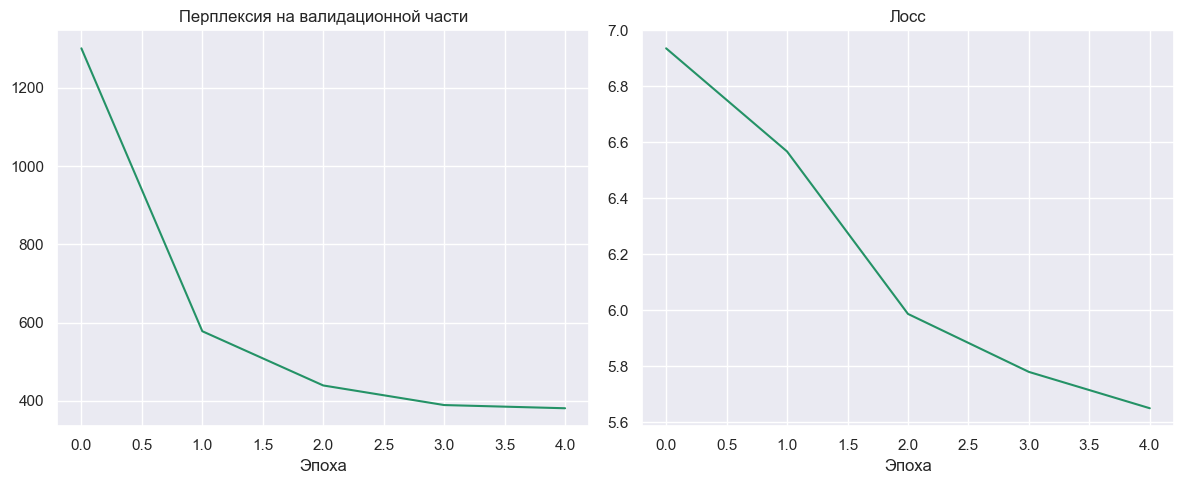

Минимальная перплексия: 380.7319087538608


In [45]:
torch.cuda.empty_cache()
model_lstm_3 = LanguageModel_3(hidden_dim=516, vocab_size=len(vocab)).to(device)
losses_lstm_3, perplexities_eval_lstm_3 = train_model(model_lstm_3, train_dataloader, eval_dataloader, num_epoch=5)
draw(losses_lstm_3, perplexities_eval_lstm_3)

In [46]:
generate_sequence(model_lstm_3, "that film is so bad that is")

'<bos> that film is so bad that is a good movie <eos>'

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [51]:
model_list = [model_rnn, model_lstm, model_lstm_drop, model_lstm_deep_layer, model_lstm_3]

In [53]:
test_preplex = []
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
for model in model_list:
    test_preplex.append(evaluate(model, criterion, test_dataloader))

In [63]:
df = {
    " " : ["Тип слоя", "Количество слоёв", "Размер скрытого слоя", "Вероятность дропаута", "Тестовая пералексия"],
    "Эксперимент 1" : ["RNN", 1, 256, 0.1, test_preplex[0]],
    "Эксперимент 2" : ["LSTM", 1, 256, 0.1, test_preplex[1]],
    "Эксперимент 3" : ["LSTM", 1, 256, 0.33, test_preplex[2]],
    "Эксперимент 4" : ["LSTM", 2, 512, 0.2, test_preplex[3]],
    "Эксперимент 5" : ["GRU", 3, 512, 0.2, test_preplex[4]],
    }

In [64]:
import pandas as pd
df = pd.DataFrame(df)
df = df.set_index(" ")
df

,Эксперимент 1,Эксперимент 2,Эксперимент 3,Эксперимент 4,Эксперимент 5
,,,,,
Тип слоя,RNN,LSTM,LSTM,LSTM,GRU
Количество слоёв,1,1,1,2,3
Размер скрытого слоя,256,256,256,512,512
Вероятность дропаута,0.1,0.1,0.33,0.2,0.2
Тестовая пералексия,213.638133,187.398304,228.66698,196.127242,375.80996


Описания поведений моделей приводились по ходу. Видно, что лучший результат показало применение LSTM с исходными параметрами. Однако модели с большими количествами слоёв и скрытым слое не смотря на худшие результаты не показывали тенденцию к переобучению. Возможно стоило попытаться учить их дальше

Для улучшения качества моделей можно предпринять следующие шаги:
* Использование не жадных алгоритмов выбора следующего слова, например beam search
* Увеличение тренировочного датасета
* Увеличение словоря
* Улучшение качества предобработки текста (оставление пунктуации и другие методы)
* Поиск оптимальной архитектуры, шага обуения/оптимизатора
* Увеличение количества эпох обучения на оптимальной архитектуре
* Использование альтернативных методов регуляризации